# Przewidywanie ceny indyjskich samochodów

## Wstęp
Celem tej analizy jest zrozumienie zmiennych wpływających na ceny samochodów używanych, sprzedawanych przez największego indyjskiego dealera CarDekho, oraz próba przewidzenia cen na podstawie dostępnych danych za pomocą regresji liniowej.

## Opis zbioru danych
W analizie korzystam ze zbioru danych Old car price prediction, udostępnionego na portalu Kaggle (https://www.kaggle.com/datasets/milanvaddoriya/old-car-price-prediction). 
Autor zbioru pozyskał dane ze strony internetowej indyjskiego dealera samochdów używanych, CarDekho (https://www.cardekho.com/used-car-details).

Zbiór zawiera 5512 pozycje oraz składa się z 9 zmiennych:
- car_name - pełna nazwa samochodu
- car_prices_in_rupee - cena samochodu w rupiach
- kms_driven - przebieg samochodu
- fuel_type - rodzaj paliwa
- transmission - rodzaj skrzyni biegów (manualna lub automatyczna)
- ownership - którym właścicielem jest sprzedający
- manufacture - rok produkcji
- engine - pojemność silnika w centymetrach sześciennych
- seats - liczba siedzeń

## Wstępna analiza

In [1]:
##ładowanie bibliotek

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
##wczytywanie zbioru danych
df = pd.read_csv('car_price.csv', index_col = 0) ##używam pierwszej kolumny jako indeksu

In [3]:
##ogólne informacje na temat zbioru danych
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5512 entries, 0 to 5511
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   car_name             5512 non-null   object
 1   car_prices_in_rupee  5512 non-null   object
 2   kms_driven           5512 non-null   object
 3   fuel_type            5512 non-null   object
 4   transmission         5512 non-null   object
 5   ownership            5512 non-null   object
 6   manufacture          5512 non-null   int64 
 7   engine               5512 non-null   object
 8   Seats                5512 non-null   object
dtypes: int64(1), object(8)
memory usage: 430.6+ KB


Obecnie wszystkie zmienne oprócz zmiennej manufacture są typu object, więc przed dokonaniem analizy trzeba będzie dokonać odpowiednich przekształceń.

In [4]:
##sprawdzanie duplikatów
df[df.duplicated()].count()

car_name               76
car_prices_in_rupee    76
kms_driven             76
fuel_type              76
transmission           76
ownership              76
manufacture            76
engine                 76
Seats                  76
dtype: int64

In [5]:
##usuwanie duplikatów
df = df.drop_duplicates()
df.shape

(5436, 9)

Po usunięciu duplikatów w zbiorze pozostało 5436 obserwacji.

In [6]:
##sprawdzanie braków danych
df[df.isna()].count()

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

W zbiorze nie ma żadnych braków danych.

In [7]:
##sprawdzanie ogólnej struktury danych
df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


W celu przeprowadzenia analizy, przekształcę zmienne tak, aby otrzymać zmienne numeryczne oraz binarne.

## Przekształcenie zmiennych

W pierwszej kolejności usunę jednostki użyte przy zmiennych kms_driven, ownership, engine oraz seats, a także przekształcę je na zmienne numeryczne.

In [8]:
df['kms_driven'] = df['kms_driven'].str.replace(' kms', '')
df['kms_driven'] = df['kms_driven'].str.replace(',', '')
df['kms_driven'] = df['kms_driven'].astype(int)
df['engine'] = df['engine'].str.replace(' cc', '').astype(int)
df['Seats'] = df['Seats'].str.replace(' Seats', '')
df['Seats'] = df['Seats'].str.replace(' Seat', '').astype(int)
df['ownership'] = df['ownership'].str.extract('(\d)').astype(int)

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ematrejek\AppData\Local\Temp\ipykernel_14544\3490320084.py:7: SyntaxWarning: invalid escape sequence '\d'
  df['ownership'] = df['ownership'].str.extract('(\d)').astype(int)


Cena samochodu, czyli zmienna "car_prices_in_rupee", zawiera wartości wyrażone w Lakh oraz Crore. 1 Crore to 100 Lakh, natomiast 1 Lakh to 100 000 rupii. Ujednolicę tą zmienną tak, aby otrzymać wartości wyrażone wyłącznie w rupiach.

In [9]:
##definiuję funkcję, która przekształci cenę wyrażoną w Crore na cenę wyrażoną w Lakh
def crore_to_lakh(price_str):
    if 'Crore' in price_str:
        crore_part, lakh_part = price_str.split(' Crore')
        crore_value = float(crore_part)
        lakh_value = crore_value * 100
        return f"{lakh_value} Lakh"
    else:
        return price_str

##stosuję funkcję do kolumny za pomocą apply
df['car_prices_in_rupee'] = df['car_prices_in_rupee'].apply(crore_to_lakh)

##usuwam jednostki i zmieniam na typ zmiennoprzecinkowy
df['car_prices_in_rupee'] = df['car_prices_in_rupee'].str.replace(' Lakh', '')
df['car_prices_in_rupee'] = df['car_prices_in_rupee'].str.replace(',', '').astype(float)

##definiuję funkcję, która przekształci Lakh na rupie
def lakh_to_rupee(price):
    if price < 1000:
        price = price*100000
        return price
    else:
        return price

df['car_prices_in_rupee'] = df['car_prices_in_rupee'].apply(lakh_to_rupee)

df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,Jeep Compass 2.0 Longitude Option BSIV,1003000.0,86226,Diesel,Manual,1,2017,1956,5
1,Renault Duster RXZ Turbo CVT,1283000.0,13248,Petrol,Automatic,1,2021,1330,5
2,Toyota Camry 2.5 G,1640000.0,60343,Petrol,Automatic,1,2016,2494,5
3,Honda Jazz VX CVT,777000.0,26696,Petrol,Automatic,1,2018,1199,5
4,Volkswagen Polo 1.2 MPI Highline,515000.0,69414,Petrol,Manual,1,2016,1199,5


W następnym kroku zajmuję się zmiennymi, które w zbiorze mają typ "string", a powinny być zmiennymi numerycznymi lub binarnymi.
Będą to zmienne fuel_type oraz transmission.
Przekształcę także zmienną manufacture tak, żeby przedstawiała wiek samochodu w celu ułatwienia późniejszej interpretacji.

            count          mean           std       min       25%        50%  \
fuel_type                                                                      
Cng          80.0  4.000875e+05  1.771465e+05  130000.0  258000.0   387500.0   
Diesel     2381.0  1.519127e+06  2.155244e+06   55000.0  427000.0   740000.0   
Electric     14.0  1.346643e+06  7.755652e+05  321000.0  471250.0  1500000.0   
Lpg          28.0  1.572846e+05  6.977882e+04   59736.0  105250.0   130000.0   
Petrol     2933.0  8.817276e+05  1.757610e+06   35000.0  260000.0   450000.0   

                 75%         max  
fuel_type                         
Cng         490000.0    906000.0  
Diesel     1625000.0  19000000.0  
Electric   2110000.0   2300000.0  
Lpg         221250.0    281000.0  
Petrol      745000.0  19200000.0  


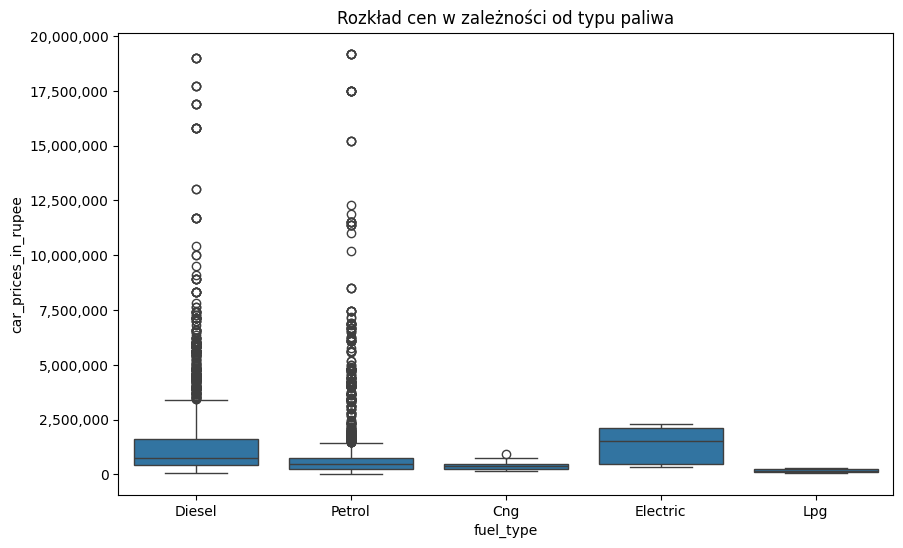

In [10]:
##sprawdzam, jak wygląda rozkład zmiennej fuel_type oraz analizuję, jak kształtuje się cena w zależności od wartości tej zmiennej

##statystyki opisowe dla typów paliwa

summary_stats = df.groupby('fuel_type')['car_prices_in_rupee'].describe()
print(summary_stats)

##wykres pudełkowy ceny samochodu w zależności od typu paliwa
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel_type', y='car_prices_in_rupee', data=df)
plt.title('Rozkład cen w zależności od typu paliwa')
formatter = FuncFormatter(lambda x, _: format(int(x), ','))
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

Z racji, że samochodów na gaz (LPG, CNG) oraz elektrycznych jest stosunkowo mało, w celu uproszczenia dalszej analizy, wybiorę jedynie samochody na benzynę (petrol) oraz Diesle.

In [11]:
df = df[df['fuel_type'].isin(['Diesel', 'Petrol'])]

In [12]:
##zamieniam rok produkcji na wiek samochodu w celu łatwiejszej interpretacji i analizy

def year_to_age(year):
    age = 2023 - year
    return age

df['manufacture'] = df['manufacture'].apply(year_to_age)

In [13]:
##zamiana fuel_type i transmission na zmienne binarne

df['fuel_type'] = df['fuel_type'].apply(lambda x: 1 if x == 'Diesel' else 0)
df['transmission'] = df['transmission'].apply(lambda x: 1 if x == 'Manual' else 0)

df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,Jeep Compass 2.0 Longitude Option BSIV,1003000.0,86226,1,1,1,6,1956,5
1,Renault Duster RXZ Turbo CVT,1283000.0,13248,0,0,1,2,1330,5
2,Toyota Camry 2.5 G,1640000.0,60343,0,0,1,7,2494,5
3,Honda Jazz VX CVT,777000.0,26696,0,0,1,5,1199,5
4,Volkswagen Polo 1.2 MPI Highline,515000.0,69414,0,1,1,7,1199,5


Do dalszej analizy wykorzystam wszystkie zmienne oprócz nazwy samochodu.

In [14]:
##zmiana nazw kolumn
new_columns = ['car_name','price', 'kms_driven', 'is_diesel', 'is_manual', 'ownership', 'age', 'engine', 'seats']
df.columns = new_columns

##tworzenie nowego zbioru do analizy
df_to_analyze = df[['price', 'kms_driven', 'is_diesel', 'is_manual', 'ownership', 'age', 'engine', 'seats']]
df_to_analyze.head()

,price,kms_driven,is_diesel,is_manual,ownership,age,engine,seats
0,1003000.0,86226,1,1,1,6,1956,5
1,1283000.0,13248,0,0,1,2,1330,5
2,1640000.0,60343,0,0,1,7,2494,5
3,777000.0,26696,0,0,1,5,1199,5
4,515000.0,69414,0,1,1,7,1199,5


In [15]:
##typy zmiennych po przekształceniach
df_to_analyze.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5314 entries, 0 to 5511
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       5314 non-null   float64
 1   kms_driven  5314 non-null   int32  
 2   is_diesel   5314 non-null   int64  
 3   is_manual   5314 non-null   int64  
 4   ownership   5314 non-null   int32  
 5   age         5314 non-null   int64  
 6   engine      5314 non-null   int32  
 7   seats       5314 non-null   int32  
dtypes: float64(1), int32(4), int64(3)
memory usage: 290.6 KB


Zmienną objaśnianą jest zmienna price, a zmiennymi objaśniającymi - pozostałe zmienne zbioru df_to_analyze.

## Statystyki opisowe zmiennych

In [16]:
df_to_analyze.describe()

,price,kms_driven,is_diesel,is_manual,ownership,age,engine,seats
count,5.314000e+03,5314.000000,5314.000000,5314.000000,5314.000000,5314.000000,5314.000000,5314.000000
mean,1.167322e+06,63245.896876,0.448062,0.717162,1.423974,7.561347,1534.748965,5.250847
std,1.971313e+06,42110.526207,0.497342,0.450421,0.703810,3.933249,579.929631,0.720831
min,3.500000e+04,250.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
25%,3.172500e+05,33000.000000,0.000000,0.000000,1.000000,5.000000,1197.000000,5.000000
50%,5.500000e+05,59000.000000,0.000000,1.000000,1.000000,7.000000,1396.000000,5.000000
75%,1.039750e+06,84279.500000,1.000000,1.000000,2.000000,10.000000,1950.000000,5.000000
max,1.920000e+07,560000.000000,1.000000,1.000000,5.000000,28.000000,5950.000000,8.000000


Z powyższych statystyk można wywnioskować, że średnia cena samochodu w zbiorze wynosi 1 167 732 rupii. 44.8% samochodów to Diesle, a 71.7% samochodów posiada manualne skrzynie biegów. Średni wiek sprzedawanego samochodu to nieco ponad 7.5 roku. 
Średnia pojemność silnika to 1535 cm^2. Dominują samochody 5-osobowe. 
Średni przebieg samochodu to nieco ponad 63 tys. km.

Można również zauważyć, że w zbiorze występują samochody bez podanej pojemności silnika. 

In [17]:
##obsługa braków danych

##sprawdzam, ile samochodów nie ma podanej pojemności silnika
df_to_analyze['engine'].value_counts().get(0, 0)

10

Jedynie 10 samochodów nie ma podanej pojemności silnika, dlatego braki te wypełnię średnią dla zbioru.

In [18]:
##sprawdzam średnią bez uwzględnienia wartości 0
average_engine_capacity = df_to_analyze[df_to_analyze['engine'] != 0]['engine'].mean()
average_engine_capacity

1537.6425339366515

In [19]:
df_to_analyze['engine'] = df_to_analyze['engine'].apply(lambda x: average_engine_capacity if x == 0 else x)
df_to_analyze.describe()

C:\Users\ematrejek\AppData\Local\Temp\ipykernel_14544\2529171573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_analyze['engine'] = df_to_analyze['engine'].apply(lambda x: average_engine_capacity if x == 0 else x)


,price,kms_driven,is_diesel,is_manual,ownership,age,engine,seats
count,5.314000e+03,5314.000000,5314.000000,5314.000000,5314.000000,5314.000000,5314.000000,5314.000000
mean,1.167322e+06,63245.896876,0.448062,0.717162,1.423974,7.561347,1537.642534,5.250847
std,1.971313e+06,42110.526207,0.497342,0.450421,0.703810,3.933249,576.087354,0.720831
min,3.500000e+04,250.000000,0.000000,0.000000,0.000000,1.000000,624.000000,2.000000
25%,3.172500e+05,33000.000000,0.000000,0.000000,1.000000,5.000000,1197.000000,5.000000
50%,5.500000e+05,59000.000000,0.000000,1.000000,1.000000,7.000000,1396.000000,5.000000
75%,1.039750e+06,84279.500000,1.000000,1.000000,2.000000,10.000000,1950.000000,5.000000
max,1.920000e+07,560000.000000,1.000000,1.000000,5.000000,28.000000,5950.000000,8.000000


## Wykresy rozkładu oraz korelacji zmiennych

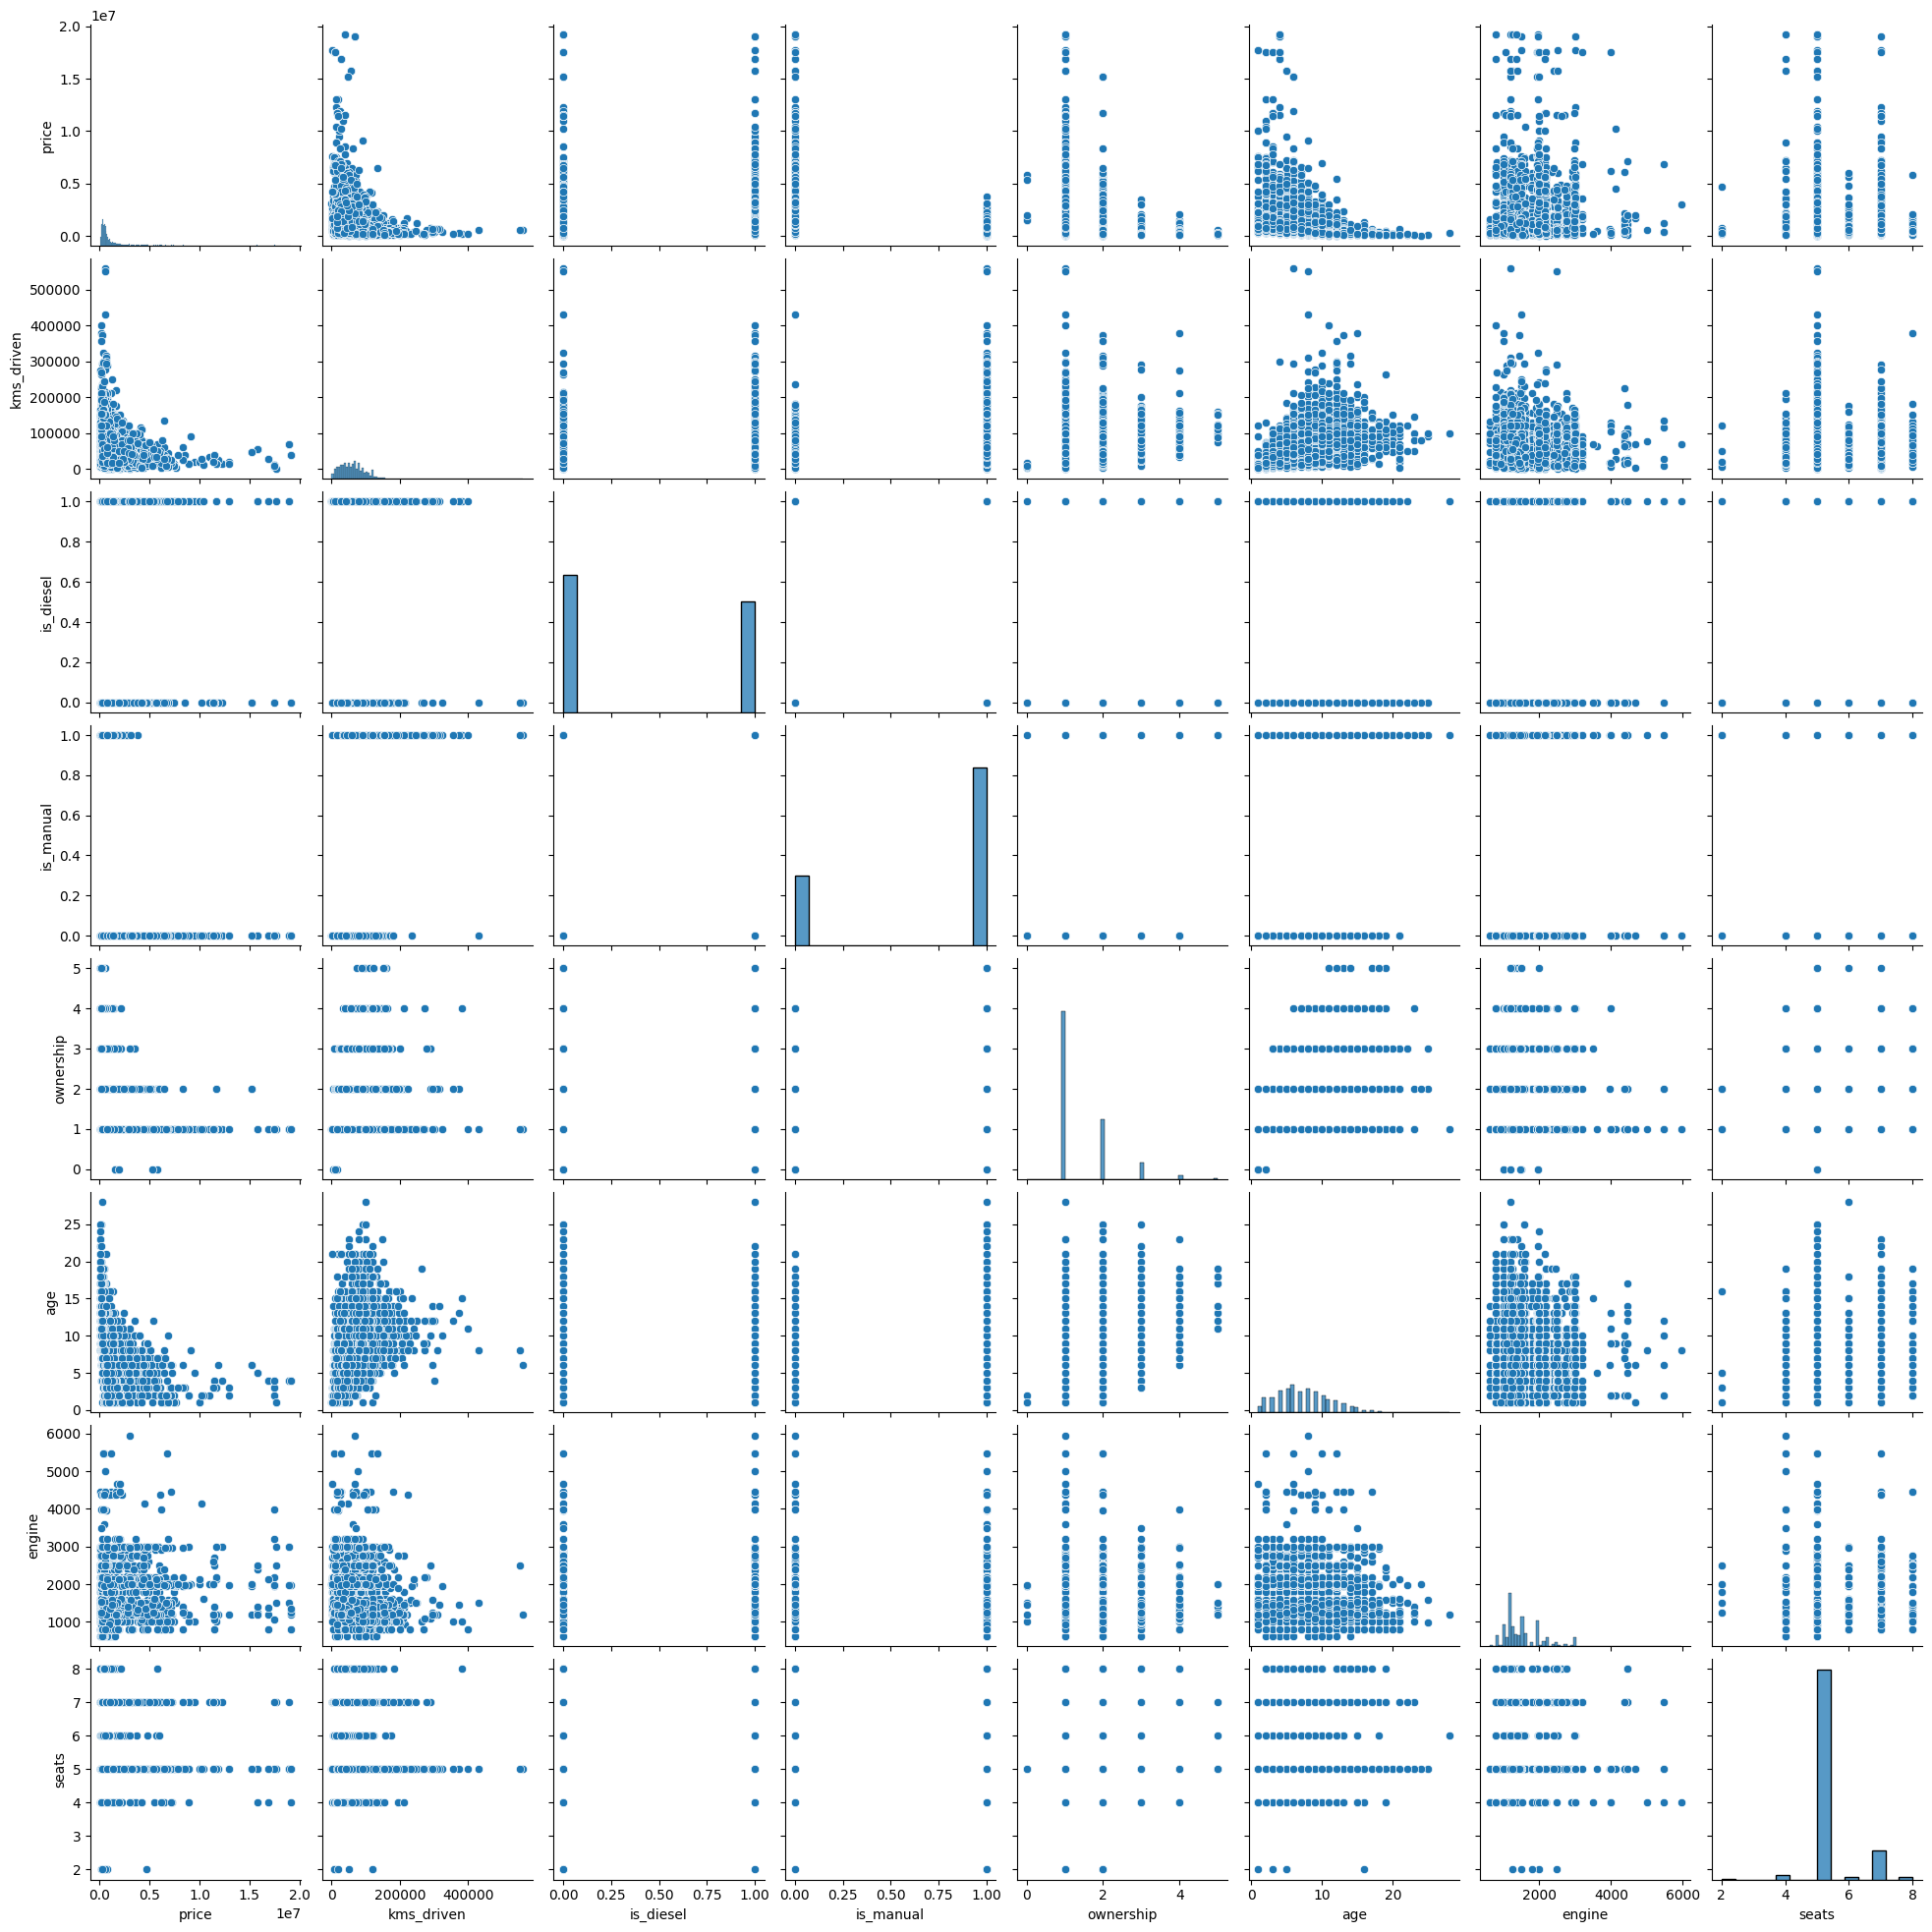

In [20]:
##scatterploty wzajemnych zależności zmiennych

sns.pairplot(df_to_analyze)

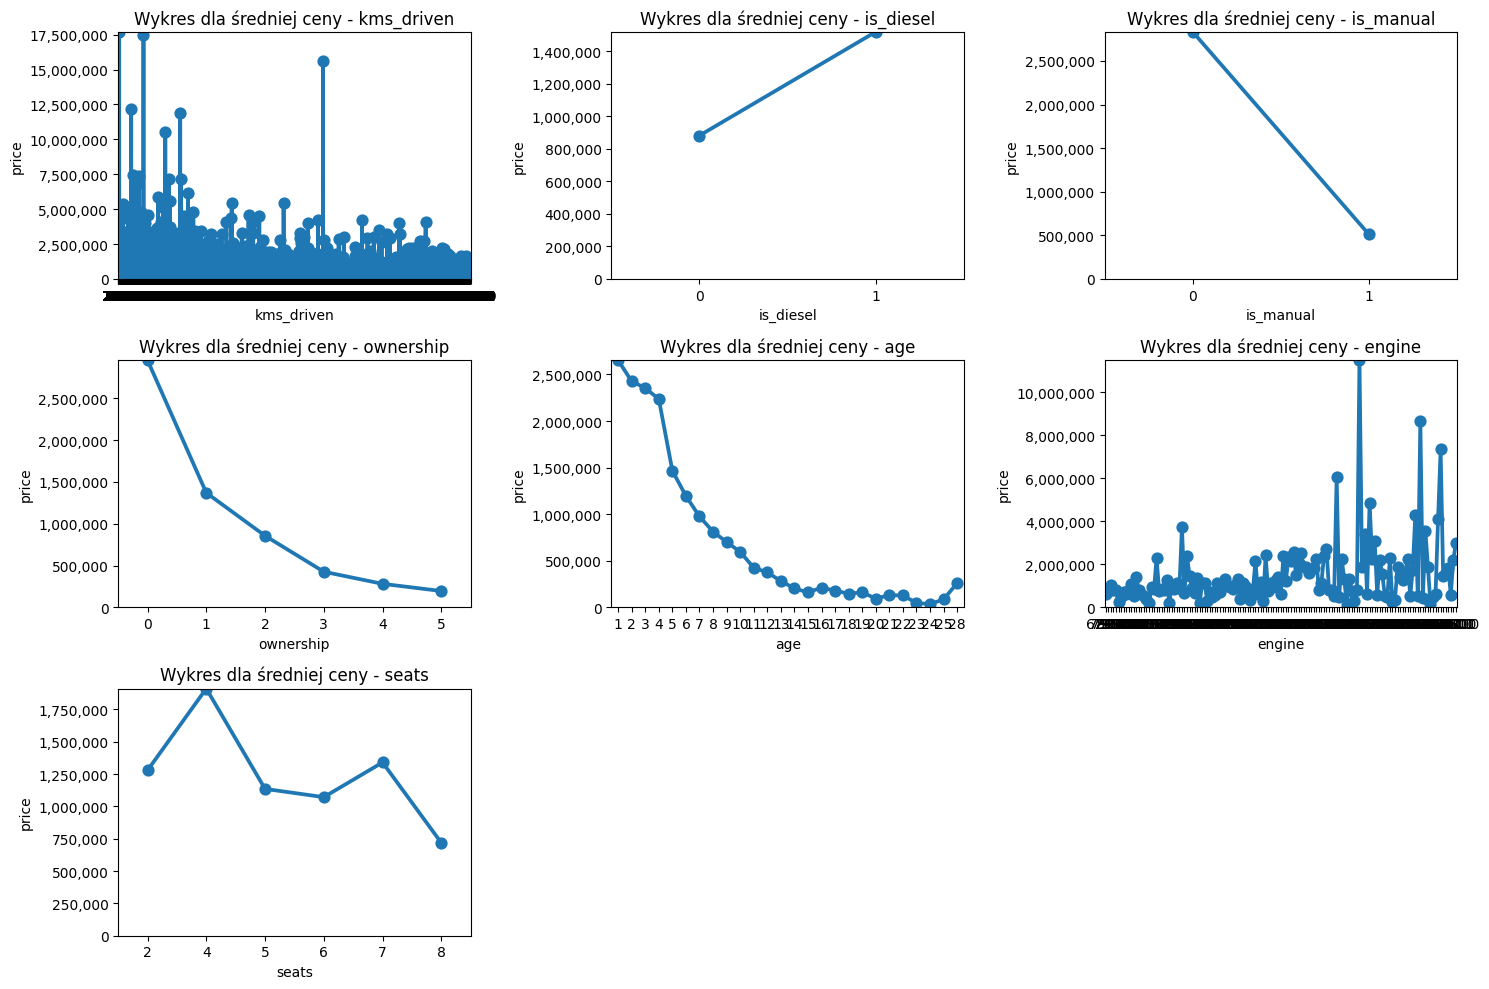

In [21]:
##wykresy pokazujące, jak kształtuje się średnia cena w zależności od wartości poszczególnych zmiennych
variables = ['kms_driven', 'is_diesel', 'is_manual', 'ownership', 'age', 'engine', 'seats']


plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 3, i)
    sns.pointplot(x=var, y='price', data=df_to_analyze, errorbar=None, estimator=np.mean)
    formatter = FuncFormatter(lambda x, _: format(int(x), ','))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.autoscale(axis='y', tight=True)
    plt.ylim(ymin=0)
    plt.title(f'Wykres dla średniej ceny - {var}')
plt.tight_layout()
plt.show()

Widać znaczne różnice pomiędzy poszczególnymi typami paliwa oraz skrzyni biegów. Można też powiedzieć, że im więcej samochód miał właścicieli, tym niższa cena, oraz im starszy samochód, tym niższa cena. Dla zmiennych kms_driven oraz engine cena przyjmuje czasami wartości odstajace od średnich, ale również można sformułować zależność, że im większy przebieg, tym niższa cena oraz im większy silnik, tym wyższa cena.

Dla zmiennej seats zależność nie jest oczywista, większe wartości dla samochodów 4- oraz 7-osobowych mogą wynikać z niewielkiej liczebności grup, w których mogły zaistnieć wartości odstające dla ceny samochodu.

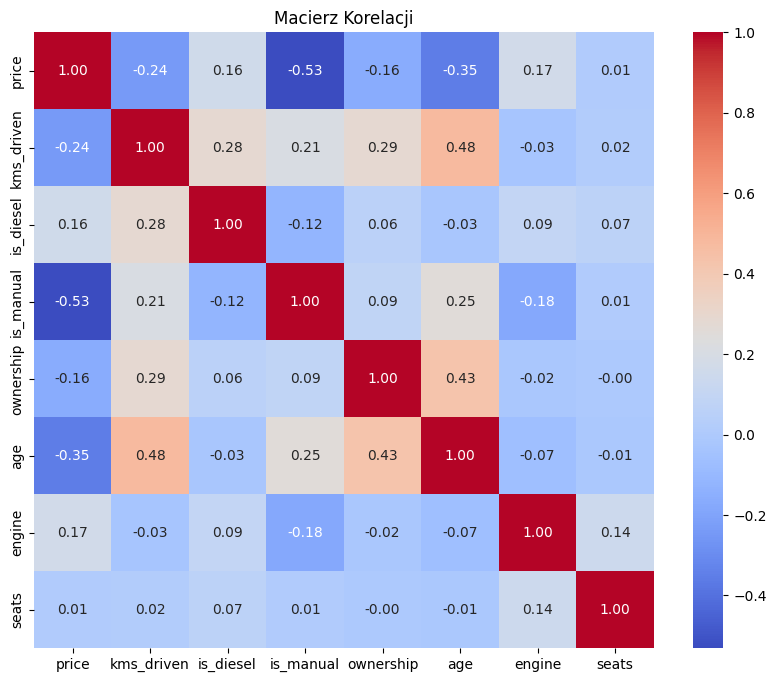

In [22]:
##heatmap dla macierzy korelacji pomiędzy zmiennymi
correlation_matrix = df_to_analyze.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
#ustawiam parametr fmt aby wyświetlić 2 miejsca po przecinku
plt.title('Macierz Korelacji')
plt.show()

Z ceną dodatnio skorelowane są zmienne is_diesel, engine oraz seats, a ujemnie - zmienne is_manual, kms_driven, ownership oraz age. Oznacza to, że droższe są Diesle, samochody o większym silniku, większej liczbie siedzeń. Im większy przebieg, tym niższa cena, podobnie im starszy samochód, tym niższa cena, tańsze są również samochody z manualną skrzynią biegów. 

Według macierzy korelacji, z ceną najsilniej skorelowany jest rodzaj skrzyni biegów oraz wiek samochodu, jednak żadna ze zmiennych nie wykazuje bardzo silnej korelacji z ceną.

## Wykres rozkładu zmiennej zależnej

C:\Users\ematrejek\AppData\Local\Temp\ipykernel_14544\2930715992.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_to_analyze['price'])


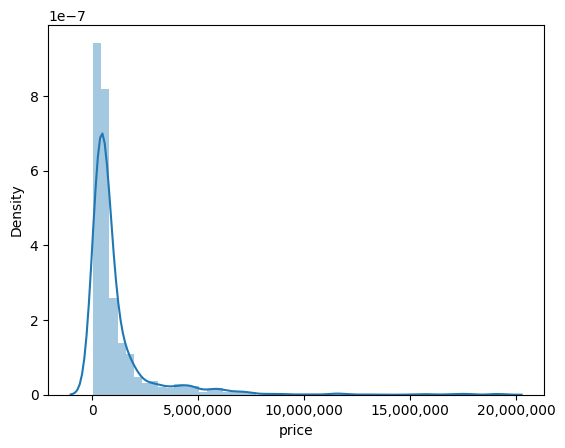

In [23]:
sns.distplot(df_to_analyze['price'])
formatter = FuncFormatter(lambda x, _: format(int(x), ','))
plt.gca().xaxis.set_major_formatter(formatter)

Cena samochodu ma rozkład prawoskośny - najwięcej jest cen stosunkowo niskich, do 5 mln rupii, ale w zbiorze znajdują się bardzo drogie samochody za prawie 20 mln rupii. 

## Modele regresji liniowej zbudowane za pomocą statsmodels oraz sklearn

### sklearn

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sn

In [25]:
##wybór zmiennych objaśniających X oraz zmiennej objaśnianej Y
X = df_to_analyze[['kms_driven', 'is_diesel', 'is_manual', 'ownership', 'age', 'engine', 'seats']]
y = df_to_analyze['price']

In [26]:
##Podział na zbiór uczący (60% obserwacji) oraz testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [27]:
##Budowa modelu
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [28]:
##wyraz wolny
print(lm.intercept_)

3234229.6703828834


In [29]:
##wyświetlanie współczynników przy zmiennych objaśniających
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
pd.set_option('display.float_format', lambda x: '%.2f' % x)
coeff_df

,Coefficient
kms_driven,-3.88
is_diesel,494237.09
is_manual,-1928175.84
ownership,-123137.49
age,-83067.82
engine,139.26
seats,-14480.01


Interpretacja współczynników:
- Każdy kolejny kilometr przebiegu powoduje spadek ceny samochodu o 3.88 rupii, ceteris paribus
- Diesle są o 494 237.09 rupii droższe od samochodów na benzynę, ceteris paribus
- Jeżeli samochód posiada manualną skrzynię biegów, wiąże się to ze spadkiem ceny o 1 928 175.84 rupii, ceteris paribus
- Każdy kolejny zarejestrowany właściciel samochodu obniża jego cenę o 123 137.49 rupii, ceteris paribus
- Z każdym kolejnym rokiem samochód jest wart 83 067.82 rupii mniej, ceteris paribus
- Wzrost pojemności silnika o 139.26 cm^3 powoduje wzrost ceny samochodu o 139.26 rupii, ceteris paribus
- Wraz ze wzrostem liczby siedzeń w samochodzie o kolejne siedzenie, cena samochodu spada o 14 480.01 rupii, ceteris paribus

### statsmodels

In [30]:
##budowa modelu
model = sn.OLS(y_train, X_train)
results = model.fit()

In [31]:
##wyświetlanie wyników 
coeff_df2 = pd.DataFrame(results.params,columns=['Coefficient'])
pd.set_option('display.float_format', lambda x: '%.2f' % x)
coeff_df2

,Coefficient
kms_driven,-3.75
is_diesel,534318.87
is_manual,-1750689.23
ownership,-24106.21
age,-67007.56
engine,308.58
seats,461662.96


Interpretacja współczynników:
- Każdy kolejny kilometr przebiegu powoduje spadek ceny samochodu o 3.75 rupii, ceteris paribus
- Diesle są o 534 318.87 rupii droższe od samochodów na benzynę, ceteris paribus
- Jeżeli samochód posiada manualną skrzynię biegów, wiąże się to ze spadkiem ceny o 1 750 689.23 rupii, ceteris paribus
- Każdy kolejny zarejestrowany właściciel samochodu obniża jego cenę o 24 106.21 rupii, ceteris paribus
- Z każdym kolejnym rokiem samochód jest wart 67 007.56 rupii mniej, ceteris paribus
- Wzrost pojemności silnika o 139.26 cm^3 powoduje wzrost ceny samochodu o 308.58 rupii, ceteris paribus
- Wraz ze wzrostem liczby siedzeń w samochodzie o kolejne siedzenie, cena samochodu wzrasta o 461 662.96 rupii, ceteris paribus

W modelu uzyskanym za pomocą pakietu statsmodels różni się znak współczynnika przy zmiennej seats oraz wartości pozostałych współczynników. Model ten budowany jest jednak bez wyrazu wolnego. W kolejnym kroku zbuduję za pomocą pakietu statsmodels model z wyrazem wolnym, a na końcu analizy porównam wyniki.

In [32]:
model_without_intercept = model
results_without_intercept = results

In [33]:
X_train_with_intercept = sn.add_constant(X_train)
model_with_intercept = sn.OLS(y_train, X_train_with_intercept)
results_with_intercept = model_with_intercept.fit()
coeff_df3 = pd.DataFrame(results_with_intercept.params,columns=['Coefficient'])
pd.set_option('display.float_format', lambda x: '%.2f' % x)
coeff_df3

,Coefficient
const,3234229.67
kms_driven,-3.88
is_diesel,494237.09
is_manual,-1928175.84
ownership,-123137.49
age,-83067.82
engine,139.26
seats,-14480.01


W modelu z wyrazem wolnym współczynniki równe są tym oszacowanym za pomocą pakietu sklearn.

## Predykcje i ocena dopasowania na zbiorze testowym

### Predykcje na zbiorze testowym

In [34]:
##model z wyrazem wolnym
predictions_with_intercept = lm.predict(X_test)

In [35]:
##model bez wyrazu wolnego
predictions_without_intercept = results_without_intercept.predict(X_test)

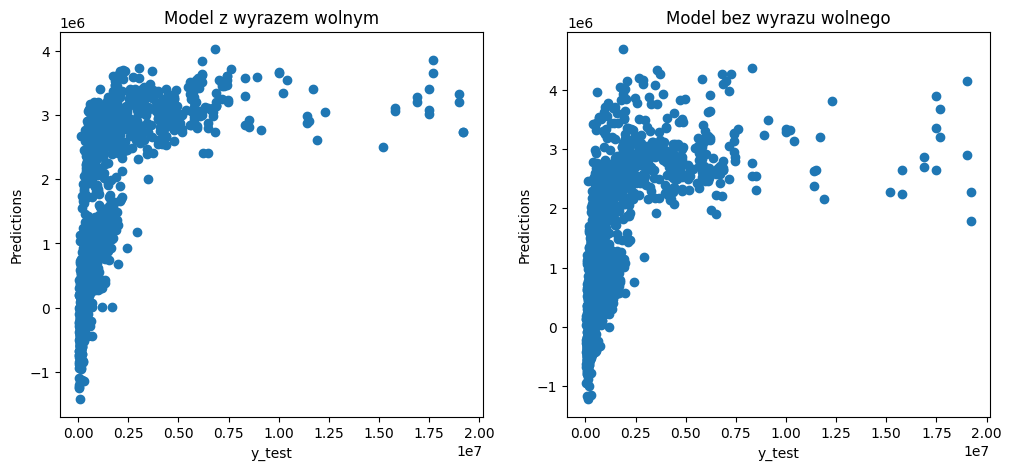

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(y_test, predictions_with_intercept)
ax1.set_title('Model z wyrazem wolnym')
ax1.set_xlabel('y_test')
ax1.set_ylabel('Predictions')
ax2.scatter(y_test, predictions_without_intercept)
ax2.set_title('Model bez wyrazu wolnego')
ax2.set_xlabel('y_test')
ax2.set_ylabel('Predictions')
plt.show()

### Wykresy reszt

C:\Users\ematrejek\AppData\Local\Temp\ipykernel_14544\536818379.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test-predictions_with_intercept),bins=50, kde = True, ax = ax1)
C:\Users\ematrejek\AppData\Local\Temp\ipykernel_14544\536818379.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distpl

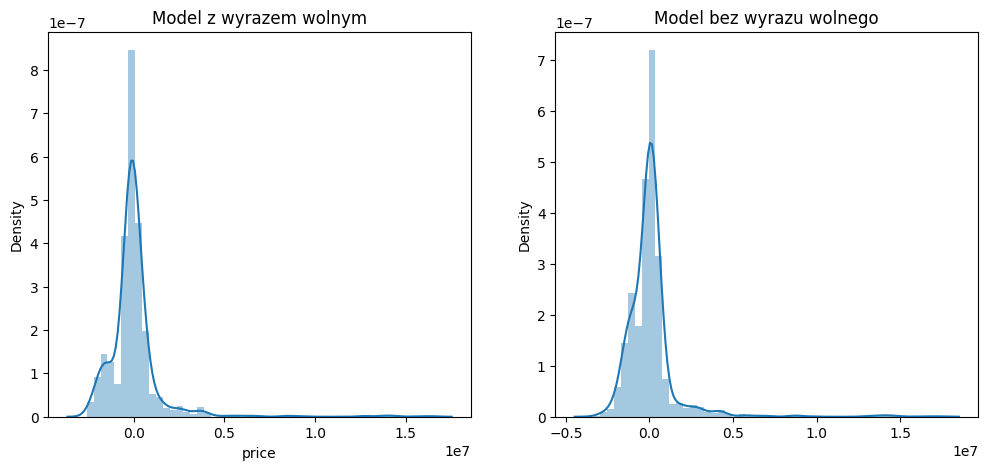

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.distplot((y_test-predictions_with_intercept),bins=50, kde = True, ax = ax1)
ax1.set_title("Model z wyrazem wolnym")
sns.distplot((y_test-predictions_without_intercept), bins=50, kde = True, ax = ax2)
ax2.set_title("Model bez wyrazu wolnego")
plt.show()

W obydwu przypadkach reszty mają rozkład prawoskośny.

### MAE, MSE, RMSE

In [38]:
###dla modelu z wyrazem wolnym
print('MAE:', metrics.mean_absolute_error(y_test, predictions_with_intercept))
print('MSE:', metrics.mean_squared_error(y_test, predictions_with_intercept))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_with_intercept)))

MAE: 788436.8902437115
MSE: 2710881846818.066
RMSE: 1646475.5834260238


In [39]:
##dla modelu bez wyrazu wolnego
print('MAE:', metrics.mean_absolute_error(y_test, predictions_without_intercept))
print('MSE:', metrics.mean_squared_error(y_test, predictions_without_intercept))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions_without_intercept)))

MAE: 821103.65880958
MSE: 2840286865798.1196
RMSE: 1685315.0642530078


- Średnio predykcje modelu różnią się o 788 537 rupii w przypadku modelu z wyrazem wolnym, oraz o 821 104 rupii w przypadku modelu bez wyrazu wolnego
- wartości MAE, MSE oraz RMSE wskazują na to, że model z wyrazem wolnym jest lepiej dopasowany do danych niż model bez wyrazu wolnego
- im mniejsze wartości tych trzech miar, tym lepsze dopasowanie modelu do danych

## Interpretacja oszacowań modelu oraz własności statystycznych modelu

W pierwszym kroku porównam wyniki uzyskane dla modelu z wyrazem wolnym oraz bez wyrazu wolnego

In [40]:
##model z wyrazem wolnym
print(results_with_intercept.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     245.4
Date:                Tue, 28 Nov 2023   Prob (F-statistic):          1.29e-292
Time:                        19:14:43   Log-Likelihood:                -49957.
No. Observations:                3188   AIC:                         9.993e+04
Df Residuals:                    3180   BIC:                         9.998e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.234e+06    2.2e+05     14.705      0.0

In [41]:

##model bez wyrazu wolnego
print(results_without_intercept.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.487
Model:                            OLS   Adj. R-squared (uncentered):              0.486
Method:                 Least Squares   F-statistic:                              431.5
Date:                Tue, 28 Nov 2023   Prob (F-statistic):                        0.00
Time:                        19:14:43   Log-Likelihood:                         -50062.
No. Observations:                3188   AIC:                                  1.001e+05
Df Residuals:                    3181   BIC:                                  1.002e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

- Pod względem R^2 lepiej wypada model bez wyrazu wolnego - 48.7% zmienności zmiennej zależnej zostało wyjaśnione przez model (48.6% uwzględniając liczbę zmiennych objaśniających - adjusted R^2). W przypadku modelu z wyrazem wolnym, tylko 35.1% zmienności zmiennej zależnej zostało wyjaśnione przez model (34.9% uwzględniając liczbę zmiennych objaśniających).
- W przypadku obydwu modeli odrzucamy hipotezę zerową testu Walda o tym, że wszystkie zmienne są nieistotne statystycznie. 
- Ze względu na kryterium Akaike'a-Quinna (AIC), pierwszy model (z wyrazem wolnym) jest preferowany - im niższa wartość tego kryterium, tym lepsza jakość modelu
- W modelu z wyrazem wolnym nieistotna statystycznie jest zmienna seats, natomiast w modelu bez wyrazu wolnego - smienna ownership. Pozostałe zmienne są istotne statystycznie.
- Wynik testu Durbina-Watsona wskazuje na brak autokorelacji pierwszego rzędu w resztach modelu - w obydwu przypadkach
- W obydwu przypadkach test Jarque-Bera wskazuje na to, że reszty nie mają rozkładu normalnego (odrzucamy hipotezę zerową o normalności rozkładu reszt). W modelach o tak dużej liczbie obserwacji działa jednak centralne twierdze graniczne, co sprawia, że rozkład reszt będzie zbliżał się do rozkładu normalnego, zatem taki wynik testu Jarque-Bera nie jest niepokojący.

#### Podsumowując - pod względem R^2 lepiej wypada model bez wyrazu wolnego, natomiast pod względem metryk ewaluacji regresji (MAE, MSE, RMSE) oraz kryterium AIC lepszą jakość wykazuje model z wyrazem wolnym. 

## Dodatek - średnia cena w zależności od marki samochodu

In [42]:
## Wyciąganie z nazw samochodów tylko marki

df['car_name'] = df['car_name'].replace('Land Rover', 'LandRover', regex=True)
df['car_name'] = df['car_name'].str.split().str.get(0)
df['car_name'].unique()

array(['Jeep', 'Renault', 'Toyota', 'Honda', 'Volkswagen', 'Maruti',
       'Mahindra', 'Hyundai', 'Nissan', 'Kia', 'MG', 'Tata', 'BMW',
       'Mercedes-Benz', 'Datsun', 'Volvo', 'Audi', 'Porsche', 'Ford',
       'Chevrolet', 'Skoda', 'Lexus', 'LandRover', 'Mini', 'Jaguar',
       'Mitsubishi', 'Force', 'Premier', 'Fiat', 'Maserati', 'Bentley',
       'Isuzu'], dtype=object)

C:\Users\ematrejek\AppData\Local\Temp\ipykernel_14544\3557014590.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='car_name', y='price', data=sorted_df, ci=None)


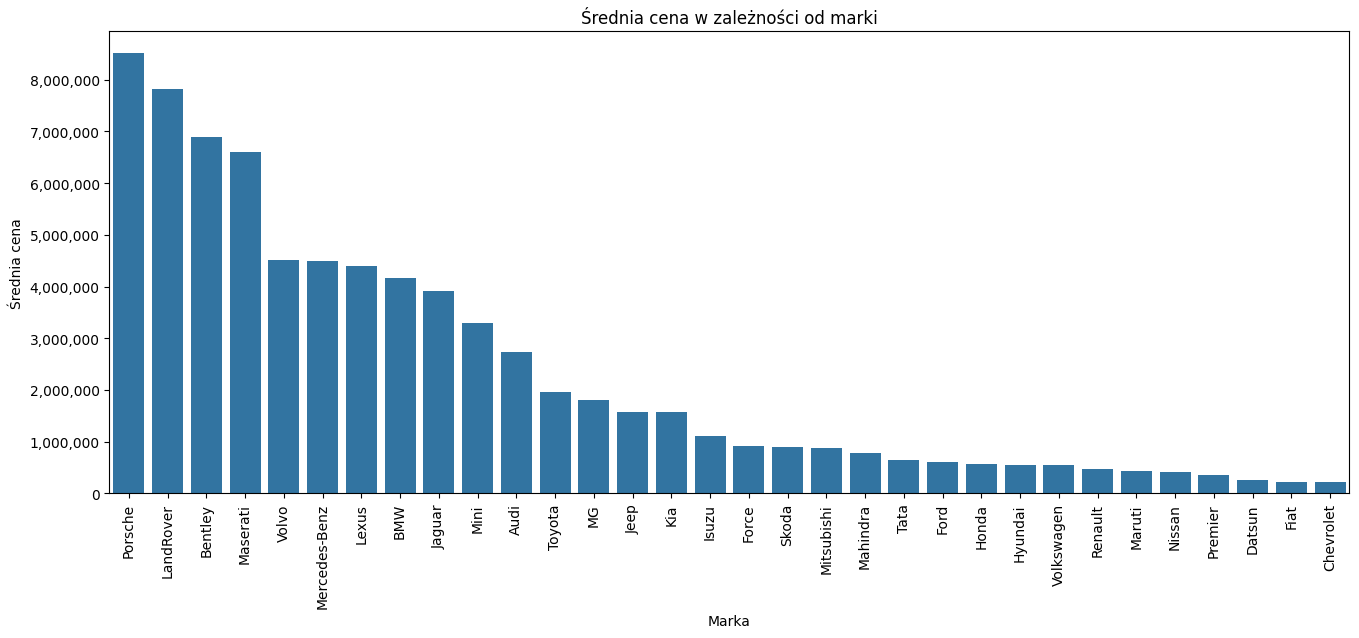

In [43]:
##sortuję w kolejności malejącej
sorted_df = df.groupby('car_name')['price'].mean().sort_values(ascending=False).reset_index()

##rysowanie wykresu
plt.figure(figsize=(16, 6))
sns.barplot(x='car_name', y='price', data=sorted_df, ci=None)
plt.title('Średnia cena w zależności od marki')
plt.xlabel('Marka')
plt.ylabel('Średnia cena')
plt.xticks(rotation=90)
formatter = FuncFormatter(lambda x, _: format(int(x), ','))
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

Najdroższe okazują się Porsche, Land Rovery, Bentleye i Maserati, a najtańsze - Fiaty i Chevrolety.